# Case Study 3 : Data Science in OpenAI Games

**Required Readings:** 
* [Deep Reinforcement Learning](http://karpathy.github.io/2016/05/31/rl/) 
* [OpenAI](https://gym.openai.com/)
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.

** NOTE **
* In this case study, you will need to use Mac OS or Linux system. In windows computers, you could use virtualbox to create a virtual machine and install an Ubuntu OS in the virtual machine.
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem: pick a data science problem that you plan to solve using OpenAI Games
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the openAI game system and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

In [ ]:
# Group 6 
# Huanhan Liu
# Qian Xu 
# Aashish Bagul
# Fangzheng Sun

# In this case, we want to use Atari games to see if deep reinforcement learning can let computer automatically play those games and try to
# get more scores episode by episode.

# If we can approve that the method could work well on Atari games, then we can use it to develop more complicated models like auto submarine
# to explore the deep ocean that human could not reach. So in this case we use Seaquest game to see the result.



# Data Exploration: Exploring the OpenAI Game System (Gym)

**1. Playing Pacman** 
We first introduce an example of how to use the gym package from OpenAI to design an agent for Pacman Game.
In the following cell, we implemented a simple agent, which randomly picks the next action without looking at the screen image (i.e., the *observation*) or the reward.

Change the following code for **myAgent** to design a better agent, which takes the observation and reward as the input and picks the best action as the next move.
The agent should be able to improve itself after playing more games.

***The goals***: Implement an agent using neural networks that can achieve all the following goals:
* (a) move the PacMan in all directions.  (5 points)
* (b) using neural network to decide what is the best next move. (5 points)
* (c) after playing each episode of the game, the agent should be able to improve itself using the experience. (5 points)

Action Code:
* 1 - UP
* 2 - RIGHT
* 3 - LEFT
* 4 - DOWN

Example code for  processing the screen image

[2017-03-10 15:18:02,574] Making new env: MsPacman-v0


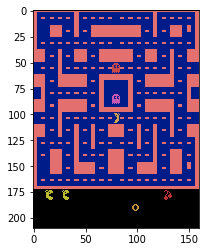

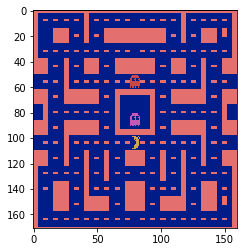

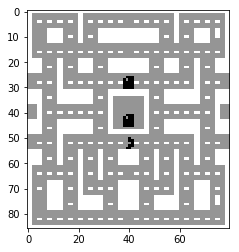

In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

env=gym.make('MsPacman-v0')

observation = env.reset()
observation, reward, done, info = env.step(1)

# plot the current screen
plt.figure(1)
plt.imshow(np.reshape(observation, (210,160,3) ))

#crop the screen
x = np.reshape(observation[0:171], (171,160,3) )
plt.figure(2)
plt.imshow(x)


# remove background
x = x[:,:,1]
x[x==111]=0
x[x==28]=1
x[x>1]=2
# downsample
x=x[::2,::2]
plt.figure(3)
plt.imshow(x,cmap='Greys')


# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

In [ ]:
# Our algorithm is based on the article Deep Reinforcement Learning: Pong from Pixels 
# In the article, the author applied neural network in Pong game. Computer makes decision of the action 
# from the historical rewards/punishments (upward or downward).
# It’s a binary choice based on the possible score of going up or down
# We use deep reinforcement learning to solve the problem and make the pacman smarter. RL is used to make computer automatically play atari games.
# To use RL, we can create neural network to let computer learn which action will be the best move in the coming situation based on
# the input which is the image of the observation.



Write codes to implement the solution in python:
***The goals***: Implement an agent using neural networks that can achieve all the following goals:
* (a) move the PacMan in all directions.  (5 points)
* (b) using neural network to decide what is the best next move. (5 points)
* (c) after playing each episode of the game, the agent should be able to improve itself using the experience. (5 points)

Action Code:
* 1 - UP
* 2 - RIGHT
* 3 - LEFT
* 4 - DOWN

* We divide the actions to odd and even numbers. 
* With odd numbers, we compare the scores of action 1 and 4, and generate the best possible action among this two. 
* With even numbers, we compare the scores of action 2 and 3, and generate the best possible action.
* As a result, pacman can move in all directions!


[2017-03-15 13:34:57,851] Making new env: MsPacman-v0


ep : 10 average episode reward total was : 169.0
ep : 20 average episode reward total was : 160.5
ep : 30 average episode reward total was : 165.0
ep : 40 average episode reward total was : 162.25
ep : 50 average episode reward total was : 167.6
ep : 60 average episode reward total was : 166.333333333
ep : 70 average episode reward total was : 166.0
ep : 80 average episode reward total was : 165.75
ep : 90 average episode reward total was : 164.555555556
ep : 100 average episode reward total was : 165.3
ep : 110 average episode reward total was : 166.454545455
ep : 120 average episode reward total was : 165.75
ep : 130 average episode reward total was : 163.923076923
ep : 140 average episode reward total was : 164.5
ep : 150 average episode reward total was : 164.666666667
ep : 160 average episode reward total was : 165.125
ep : 170 average episode reward total was : 166.176470588
ep : 180 average episode reward total was : 165.388888889
ep : 190 average episode reward total was : 166.

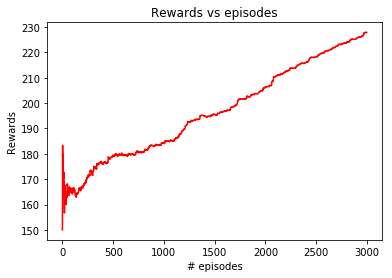

In [1]:
""" Trains an agent with (stochastic) Policy Gradients on Pacman. Uses OpenAI Gym. """
import numpy as np
import cPickle as pickle
import gym
import matplotlib.pyplot as plt

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)
  
grad_buffer = { k : np.zeros_like(v) for k,v in model.iteritems() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.iteritems() } # rmsprop memory

def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (Pacman specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("MsPacman-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
n = 0
history_sum = 0
rewards=[]

while episode_number < 3000:
    if episode_number == 2999:
        render = True

    if n%2==0:
        action_1 = 2
        action_2 = 3
    else:
        action_1 = 1
        action_2 = 4
    n+=1
    
    if render: env.render()

    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = action_1 if np.random.uniform() < aprob else action_2 # roll the dice!

    # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == action_1 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward
    
    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1
        history_sum += reward_sum
        ave = history_sum/episode_number
        rewards.append(ave)

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.iteritems():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
        #running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        
        if episode_number%10 == 0:
            print 'ep :', episode_number, 'average episode reward total was :', ave
        #running mean: %f' % (reward_sum, running_reward)
        if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None

    #if reward != 0: # Pacman has either +1 or -1 reward exactly when game ends.
    #print ('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!')

x = range(0,3000)
plt.title("Rewards vs episodes") 
plt.plot(x, rewards, color="red")
plt.xlabel("# episodes")
plt.ylabel("Rewards")
plt.show()














In [ ]:
## The following code is for Seaquest game

""" Trains an agent with (stochastic) Policy Gradients on Seaquest. Uses OpenAI Gym. """
import numpy as np
import cPickle as pickle
import gym
import matplotlib.pyplot as plt

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)
  
grad_buffer = { k : np.zeros_like(v) for k,v in model.iteritems() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.iteritems() } # rmsprop memory

def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (Seaquest specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Seaquest-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
n = 0
history_sum = 0
rewards=[]

while episode_number < 1000:
    if episode_number == 999:
        render = True

    if n%4 == 0:
        action_1 = 2
        action_2 = 5
    if n%4 == 1:
        action_1 = 1
        action_2 = 1
    if n%4 == 2:
        action_1 = 8
        action_2 = 9
    if n%4 == 3:
        action_1 = 1
        action_2 = 1
    n+=1
    
    if render: env.render()

  # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = action_1 if np.random.uniform() < aprob else action_2 # roll the dice!

  # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == action_1 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward
    
    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1
        history_sum += reward_sum
        ave = history_sum/episode_number
        rewards.append(ave)

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.iteritems():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
        #running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01

        if episode_number%5 == 0:
            print 'ep :', episode_number, 'average episode reward total was :', ave
        #running mean: %f' % (reward_sum, running_reward)
        if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None

    #if reward != 0: # Seaquest has either +1 or -1 reward exactly when game ends.
    #print ('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!')

x = range(0,1000)
plt.title("Rewards vs episodes") 
plt.plot(x, rewards, color="red")
plt.xlabel("# episodes")
plt.ylabel("Rewards")
plt.show()

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


In [ ]:
# As we can see above, the average number of rewards is increasing all the time, so our algorithm work well on pacman.
# We don't simulate too many episodes due to the time limatation, if we can have enough time, the score will increase a lot
# compared with the very firt step as you can see in our video.








*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 3".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (5 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       1: I can barely understand what data they are trying to collect/process
       2: I can barely understand why the data is relevant to the problem
       3: the data are relevant to the problem, but better data can be collected
       4: the data collected are relevant and at a proper scale
       5: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the exploration task (15 points):
       0: missing answer
       5: okay, but with major problems
      10: good, but with minor problems
      15: perfect
    
    
    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9


